# Linear regression

Consider a simple linear regression with a single feature $x$, i.e.
\begin{equation}
y = ax + b + \epsilon,
\end{equation}
where $\epsilon$ is some form of noise.

## Data generation

First, let's generate some data. We have a feature $x$ with 100 data points, and labels $a=2$, $b=1$ with Gaussian noise $e$. We split our data to training and validation sets with 80:20 split.

In [166]:
import numpy as np
import matplotlib.pyplot as plt

In [167]:
np.random.seed(0)
x = np.random.rand(100, 1)
a = 1
b = 2
y = a*x + b + 0.1*np.random.randn(100, 1)

#shuffle indices
idx = np.arange(100)
np.random.shuffle(idx)

train_idx = idx[:80]
val_idx = idx[80:]

# training and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

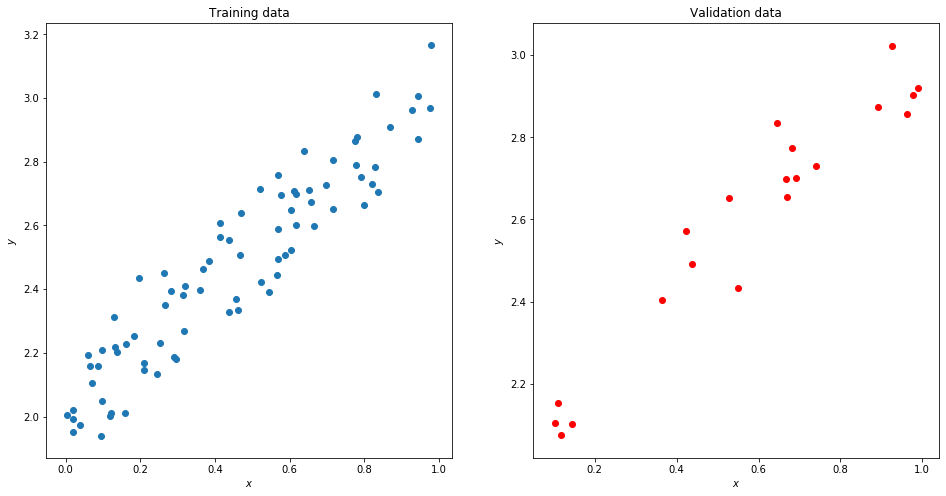

In [168]:
# plot the data
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(x_train, y_train)
ax[0].set_title("Training data")
ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$y$")

ax[1].scatter(x_val, y_val, color="r")
ax[1].set_title("Validation data")
ax[1].set_xlabel("$x$")
ax[1].set_ylabel("$y$")
plt.show()

## Linear regression in NumPy
Next, we implement a linear regression model in `NumPy` using MSE loss.

In [169]:
# initialize a and b randomly
np.random.seed(0)
a = np.random.randn(1)
b = np.random.randn(1)

print("a and b after initialization")
print(f"a={a.squeeze():.4f} b={b.squeeze():.4f}")

# set learning rate and and the number of epochs
lr = 0.1
epochs = 1000

for epoch in range(epochs):
    y_pred = a*x_train + b
    
    error = y_train - y_pred
    # MSE loss
    loss = np.mean(error**2)
    
    # compute gradients
    a_grad = -2*np.mean(x_train*error)
    b_grad = -2*np.mean(error)
    
    # update parameters
    a -= lr*a_grad
    b -= lr*b_grad

print()
print("a and b after gradient descent:")
print(f"a={a.squeeze():.4f} b={b.squeeze():.4f}")

a and b after initialization
a=1.7641 b=0.4002

a and b after gradient descent:
a=1.0044 b=2.0178


We can perform a sanity check with `LinearRegression` from `sklearn`.

In [170]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train)
intr, coeff = model.intercept_, model.coef_[0]

print(f"coefficient={coeff.squeeze():.4f} intercept={intr.squeeze():.4f}")

coefficient=1.0044 intercept=2.0179


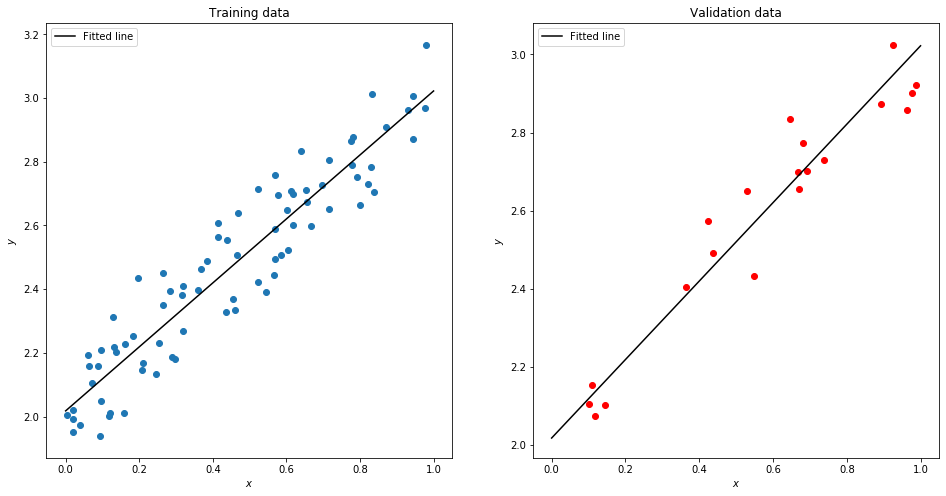

In [171]:
# plot the fitted line
x_plot = np.linspace(0, 1, 100)
y_plot = a*x_plot + b

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(x_train, y_train)
ax[0].set_title("Training data")
ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$y$")
ax[0].plot(x_plot, y_plot, color="black", label="Fitted line")
ax[0].legend()

ax[1].scatter(x_val, y_val, color="r")
ax[1].set_title("Validation data")
ax[1].set_xlabel("$x$")
ax[1].set_ylabel("$y$")
ax[1].plot(x_plot, y_plot, color="black", label="Fitted line")
ax[1].legend()
plt.show()

Seems to work well.

# PyTorch
Make the required imports, change the data to `PyTorch` tensors and send them to GPU (if available), so that we can leverage its powerful parallel computing capabilities

In [172]:
import torch
import torch.optim as optim
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.cuda.FloatTensor


## Creating parameters
Let's then create the parameters $a$ and $b$. The trainable parameters require computation of their **gradients**, so that their values can be updated. Therefore we set `requires_grad=True`. Furthermore, we create the parameter tensors directly on the device memory.

In [173]:
torch.manual_seed(0)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

tensor([-0.9247], device='cuda:0', requires_grad=True) tensor([0.1808], device='cuda:0', requires_grad=True)


## Autograd
`Autograd` is `PyTorch`'s automatic differentiation package, such that the gradients need not be computed manually. To compute the gradients w.r.t. the loss function, we need to invoke `backward()` method of the corresponding variable, e.g. `loss.backward()`. The gradients are **accumulated**, so every time they are used to update the parameters, the gradients need to be zeroed afterwards. This is accomplished with `zero_()`. The underscore stands for **in-place**.

In [174]:
lr = 0.1
epochs = 1000

torch.manual_seed(0)

a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

for epoch in range(epochs):
    y_pred = a*x_train_tensor + b
    error = y_train_tensor - y_pred
    loss = (error**2).mean()
    
    # no more manual computation of gradients
    loss.backward()
    
    #print(a.grad)
    #print(b.grad)
    
    with torch.no_grad():
        a -= lr*a.grad
        b -= lr*b.grad
        
    a.grad.zero_()
    b.grad.zero_()
    
print(a, b)

tensor([-0.9247], device='cuda:0', requires_grad=True) tensor([0.1808], device='cuda:0', requires_grad=True)
tensor([1.0044], device='cuda:0', requires_grad=True) tensor([2.0179], device='cuda:0', requires_grad=True)


We obtain the same results as before with `NumPy` and `sklearn`. The `torch.no_grad()` allows us to perform regular `Python` operations on tensors, independent of `PyTorch`'s computation graph.

## Optimizer
Thus far the parameters have been updated manually, but there's a better way. An optimizer takes the parameters to be updated, the learning rate (and other hyperparameters as well), and performs the updates via its `step()` method. In addition, the gradients need not be zeroed out one by one anymore. This is accomplished by the optimizer's `zero_grad()` method. Next, we will use SGD optimizer to update the parameters $a$ and $b$.

In [175]:
lr = 0.1
epochs = 1000

torch.manual_seed(0)

a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

# SGD optimizer
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(epochs):
    y_pred = a*x_train_tensor + b
    error = y_train_tensor - y_pred
    loss = (error**2).mean()
    
    loss.backward()
    
    optimizer.step()
        
    optimizer.zero_grad()
    
print(a, b)

tensor([-0.9247], device='cuda:0', requires_grad=True) tensor([0.1808], device='cuda:0', requires_grad=True)
tensor([1.0044], device='cuda:0', requires_grad=True) tensor([2.0179], device='cuda:0', requires_grad=True)


## Loss
Next we move on to the computation of the loss function. In this case we use the `PyTorch` implementation of MSE loss, which is only one of many options.

> Note that `nn.MSELoss()` creates a loss function, it is **not** the loss function itself.

In [176]:
lr = 0.1
epochs = 1000

torch.manual_seed(0)

a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

optimizer = optim.SGD([a, b], lr=lr)
# loss function
loss_fn = nn.MSELoss(reduction="mean")

for epoch in range(epochs):
    y_pred = a*x_train_tensor + b
    loss = loss_fn(y_train_tensor, y_pred)
    
    loss.backward()
    
    optimizer.step()
        
    optimizer.zero_grad()
    
print(a, b)

tensor([-0.9247], device='cuda:0', requires_grad=True) tensor([0.1808], device='cuda:0', requires_grad=True)
tensor([1.0044], device='cuda:0', requires_grad=True) tensor([2.0179], device='cuda:0', requires_grad=True)


## Model
A `PyTorch` model is represented as a regular `Python` class that inherits from the `Module` class. It needs to implement 
- `__init__(self)`: defines the parts that make up the model, here the parameters $a$ and $b$.
- `forward(self, x)`: performs the actual computation, i.e. outputs a prediction given input $x$. 

> However, the `forward(x)` method should not be called. The whole model should be called instead, i.e. `model(x)`.

Let's build a simple model for our linear regression task.

In [177]:
class LinearRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        # the parameters need to be wrapped inside nn.Parameter
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    
    def forward(self, x):
        return self.a*x + self.b

In the `__init__()` method we used the `Parameter()` class to define the parameters $a$ and $b$ in order to tell `PyTorch` that these tensors should be considered parameters of the model they are an attribute of. This allows us to use our model's `parameters()` method to retrieve an iterator over the parameters of the model, which can be then fed to the optimizer, so that we need not to build the list of parameters manually. Furthermore, the current values of all parameters can be obtained using the `state_dict()` method.

> **Important**: The model needs to be sent to the same device where the data resides.

The modified code then looks as follows.

In [178]:
lr = 0.1
epochs = 1000

torch.manual_seed(0)

a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

# create a model and send it to device
model = LinearRegressor().to(device)
print(model.state_dict())

optimizer = optim.SGD(model.parameters(), lr=lr)
# loss function
loss_fn = nn.MSELoss(reduction="mean")

for epoch in range(epochs):
    model.train()
    
    y_pred = model(x_train_tensor)
    
    loss = loss_fn(y_train_tensor, y_pred)
    
    loss.backward()
    
    optimizer.step()
        
    optimizer.zero_grad()
    
print(model.state_dict())

tensor([-0.9247], device='cuda:0', requires_grad=True) tensor([0.1808], device='cuda:0', requires_grad=True)
OrderedDict([('a', tensor([1.5410], device='cuda:0')), ('b', tensor([-0.2934], device='cuda:0'))])
OrderedDict([('a', tensor([1.0044], device='cuda:0')), ('b', tensor([2.0178], device='cuda:0'))])


The model's `train()` method does **not** perform a training step, but is used to set the model to **training mode**. Some models may use mechanisms, e.g. dropout, which behave distinctly different in training versus in evaluation.

### Nested models
So far we have manually created two parameters in order to perform linear regression. We can use `PyTorch`'s `Linear` model as an attribute in order to create a nested model.

In [179]:
class NestedLinearRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        # linear layer with single input and output
        self.linear = nn.Linear(1, 1)
        
    def forward(self, x):
        # call the linear layer to make predictions
        return self.linear(x)

Note that we are calling the nested model itself to perform the forward pass instead of calling `self.linear.forward(x)`. If the `parameters()` method is now called, `PyTorch` will figure them out recursively.

### Sequential models
For simple and straightforward models where the output of a layer is fed as an input to the next, we could use the `Sequential` model, instead of building a class. In our example, we could write

In [180]:
model = nn.Sequential(nn.Linear(1, 1)).to(device)

### Training step
Up to this point, we have defined an optimizer, a loss function and a model. Taking a close look inside the training loop, we can notice that if we change the optimizer, loss or even the model, the code would not really change. Thus we can make it more generic. Let's write a function that takes the three core elements (optimizer, loss, model) and returns another function which performs a training step, i.e. takes a set of features and labels as arguments and returns the corresponding loss. Then we can use this function to build a `train_step()` function to be called inside the training loop.

In [181]:
lr = 0.1
epochs = 1000

torch.manual_seed(0)

a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

def make_train_step(model, loss_fn, optimizer):
    # build the train step function
    def train_step(x, y):
        # train mode
        model.train()
        # make predictions
        y_pred = model(x)
        # compute loss
        loss = loss_fn(y, y_pred)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        # return loss
        return loss.item()
    
    # return the function to be called inside training loop
    return train_step

model = nn.Sequential(nn.Linear(1, 1)).to(device)
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.SGD(model.parameters(), lr=lr)

train_step = make_train_step(model, loss_fn, optimizer)
losses = []

# training loop is quite short now
for epoch in range(epochs):
    loss = train_step(x_train_tensor, y_train_tensor)
    losses.append(loss)
    
# print model parameters
print(model.state_dict())

tensor([-0.9247], device='cuda:0', requires_grad=True) tensor([0.1808], device='cuda:0', requires_grad=True)
OrderedDict([('0.weight', tensor([[1.0044]], device='cuda:0')), ('0.bias', tensor([2.0179], device='cuda:0'))])


We could change the model, loss and optimizer and the training loop would remain the same.

## Dataset
A `PyTorch` dataset is represented by a regular `Python` class that inherits from the `Dataset` class. It is similar to a list of tuples, each corresponding to one point `(features, label)`. It needs to implement

- `__init__(self)`: Takes whatever arguments to build a list of tuples. E.g. a file that is loaded and processed or just simply two tensors for features and labels, respectively. It is not necessary to load the whole dataset in the constructor. Instead, we load them on demand using `__getitem__()`.

- `__getitem(self, index)__`: Allows the dataset to be indexed, so that it can work as a list (`dataset[i]`). It must return a tuple `(features, label)` corresponding to the requested data point or slice.

- `__len(self)__`: Returns the size of the whole dataset so that the indexing is limited to its actual size.

Let's build a custom dataset that takes two tensors as arguments: one for the features and one for the labels. The dataset will return the corresponding slice of each of those tensors for any given index.

In [182]:
from torch.utils.data import Dataset, TensorDataset

class MyDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])
    
    def __len__(self):
        return len(self.x)
    
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = MyDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.8210]), tensor([2.7297]))
(tensor([0.8210]), tensor([2.7297]))


If the dataset is comprised of simply a few tensors, we can use the `TensorDataset` class, which achieves the same result as our custom dataset. Note that in the above we created the $x$ and $y$ tensors from `NumPy` arrays as before, but did **not** send them to `device`. This is because we don't actually want to send the whole training data to our GPU, unlike we have previously done, since its memory is limited. 

## DataLoader
Up to this point, we have used the whole training data at every training step. This is called **batch gradient descent**. It has served us well since our dataset is so small, but the situation changes drastically if the dataset grows large enough. Instead, we use **mini-batch gradient descent**, which approximates the gradient of the whole dataset by computing it from randomly selected mini-batches. This requires us to slice the dataset accordingly. In order to avoid doing this manually, we use the `DataLoader` class. We give the dataset to use as as input, the mini-batch size and if we want to shuffle the dataset or not. The `DataLoader` will behave as an iterator over the dataset, so we can loop over it and fetch different mini-batches every time.

In [183]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

To retrieve a mini-batch, we call `next(iter(train_loader))`. It will return a list of two tensors, one for features and one for labels. The training loop changes to

In [184]:
lr = 0.1
epochs = 1000

torch.manual_seed(0)

a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

def make_train_step(model, loss_fn, optimizer):

    def train_step(x, y):
        model.train()

        y_pred = model(x)

        loss = loss_fn(y, y_pred)

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        return loss.item()
    
    return train_step

model = nn.Sequential(nn.Linear(1, 1)).to(device)
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.SGD(model.parameters(), lr=lr)

train_step = make_train_step(model, loss_fn, optimizer)
losses = []

for epoch in range(epochs):
    for x_batch, y_batch in train_loader:
        # only the mini-batches are sent to GPU 
        # the rest of the training data resides in CPU memory
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        loss = train_step(x_batch, y_batch)
        losses.append(loss)
    
# print model parameters
print(model.state_dict())

tensor([-0.9247], device='cuda:0', requires_grad=True) tensor([0.1808], device='cuda:0', requires_grad=True)
OrderedDict([('0.weight', tensor([[1.0057]], device='cuda:0')), ('0.bias', tensor([2.0209], device='cuda:0'))])


In the training loop there is now an inner loop which loads the mini-batches, and most importantly, only those are sent to the `device`.

## Random Split
Since we have thus far focused on training data only, one would think we need to build a `DataSet` and `DataLoader` for the validation data as well. Fortunately, we can just build one `DataSet` for the whole data (training + validation) and use `random_split` to split it to training and validation sets and then define a corresponding `DataLoader` for both sets.

In [185]:
from torch.utils.data.dataset import random_split

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

dataset = TensorDataset(x_tensor, y_tensor)

# use 80:20 train:val split as before
train_data, val_data = random_split(dataset, [80, 20])

train_loader = DataLoader(dataset=train_data, batch_size=16)
val_loader = DataLoader(dataset=val_data, batch_size=20)

## Evaluation
Finally, we need to change the training loop to include the evaluation of our model, i.e. computing the validation loss. This requires another inner loop to handle mini-batches coming from the validation loader and sending them to the same `device` as our model. Then we make predictions with our model and compute the corresponding loss. There's two things to consider:

- `torch.no_grad()`: Wrapping the validation loop inside this context manager disables the computation of gradients, because they belong in training, not in validation.
- `eval()`: Sets the model to evaluation mode, counterpart to `train()`.

Now our training loop attains its final form.

In [186]:
lr = 0.1
epochs = 1000

torch.manual_seed(0)

a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

def make_train_step(model, loss_fn, optimizer):

    def train_step(x, y):
        model.train()

        y_pred = model(x)

        loss = loss_fn(y, y_pred)

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        return loss.item()
    
    return train_step

model = nn.Sequential(nn.Linear(1, 1)).to(device)
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.SGD(model.parameters(), lr=lr)

train_step = make_train_step(model, loss_fn, optimizer)
losses = []
val_losses = []

for epoch in range(epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            model.eval()
            
            y_pred = model(x_val)
            val_loss = loss_fn(y_val, y_pred)
            val_losses.append(val_loss.item())
    
# print model parameters
print(model.state_dict())

tensor([-0.9247], device='cuda:0', requires_grad=True) tensor([0.1808], device='cuda:0', requires_grad=True)
OrderedDict([('0.weight', tensor([[0.9897]], device='cuda:0')), ('0.bias', tensor([2.0247], device='cuda:0'))])


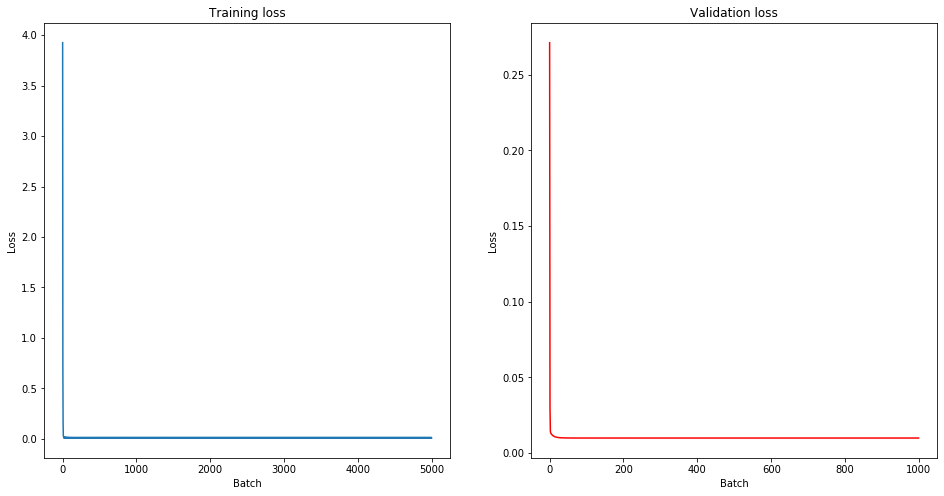

In [187]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(range(len(losses)), losses)
ax[0].set_title("Training loss")
ax[0].set_xlabel("Batch")
ax[0].set_ylabel("Loss")

ax[1].plot(range(len(val_losses)), val_losses, color="r")
ax[1].set_title("Validation loss")
ax[1].set_xlabel("Batch")
ax[1].set_ylabel("Loss")
plt.show()

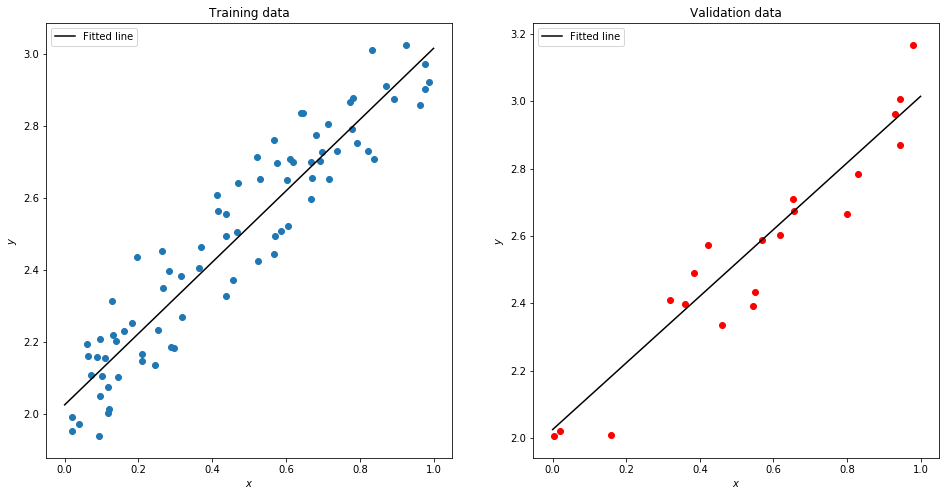

In [188]:
plot_train = np.array(train_loader.dataset)
plot_val = np.array(val_loader.dataset)

x_plot = np.linspace(0, 1, 100)
a, b = model.state_dict().values()
# need to move to CPU memory first and then convert to numpy arrays
y_plot = a.cpu().numpy().squeeze()*x_plot + b.cpu().numpy().squeeze()

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(plot_train[:, 0], plot_train[:, 1])
ax[0].set_title("Training data")
ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$y$")
ax[0].plot(x_plot, y_plot, color="black", label="Fitted line")
ax[0].legend()

ax[1].scatter(plot_val[:, 0], plot_val[:, 1], color="r")
ax[1].set_title("Validation data")
ax[1].set_xlabel("$x$")
ax[1].set_ylabel("$y$")
ax[1].plot(x_plot, y_plot, color="black", label="Fitted line")
ax[1].legend()
plt.show()

# Summary
Although for our simple linear regression task the usage of `PyTorch` might be considered overkill, it highlights the basic elements of building a deep learning model in `PyTorch`, and why its useful. Now we are ready to enter the realm of neural networks.